In [1]:
import os 
import matplotlib
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import re
import datetime
import cudf, numpy as np
from cuml import Lasso
from cuml.preprocessing.TargetEncoder import TargetEncoder
from sklearn.model_selection import KFold

from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

currentDateTime = datetime.datetime.now()
date = currentDateTime.date()
year = int(date.strftime("%Y"))

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = "#949494"

%matplotlib inline

In [2]:
od.download('https://www.kaggle.com/c/playground-series-s4e9')
os.listdir('playground-series-s4e9')
train = pd.read_csv('playground-series-s4e9/train.csv', low_memory=False)
test = pd.read_csv('playground-series-s4e9/test.csv', low_memory=False)
submision_df = pd.read_csv('playground-series-s4e9/sample_submission.csv')
train = train.copy()

Skipping, found downloaded files in "./playground-series-s4e9" (use force=True to force download)


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" 

VER=1

In [4]:
train["milage"] = (train["milage"]//1000)*1000
print("Train shape:", train.shape )
train.head(1)



test["milage"] = (test["milage"]//1000)*1000
print("Test shape:", test.shape )
test.head(1)

Train shape: (188533, 13)
Test shape: (125690, 12)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes


In [5]:
COLS = list( train.columns[1:-1] )
print( COLS )
print(len(COLS),"uni-grams exist")

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
11 uni-grams exist


In [6]:
COLS = list( train.columns[1:-1] )
print( COLS )
print(len(COLS),"uni-grams exist")

new_columns = {}
new_columns2 = {}
COLS2 = []
for i, c1 in enumerate(COLS[:-1]):
    for j, c2 in enumerate(COLS[i+1:]):
        name = f"{c1}-{c2}"
        new_columns[name] = train[c1].astype("str") + "_" + train[c2].astype("str")
        new_columns2[name] = test[c1].astype("str") + "_" + test[c2].astype("str")
        COLS2.append(name)
        print(f"{i}-{i+j+1}, ", end='')
train = cudf.concat([cudf.DataFrame(train), cudf.DataFrame(new_columns)], axis=1)
test = cudf.concat([cudf.DataFrame(test), cudf.DataFrame(new_columns2)], axis=1)
print()
print(len(COLS2),"bi-grams generated")

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
11 uni-grams exist
0-1, 0-2, 0-3, 0-4, 0-5, 0-6, 0-7, 0-8, 0-9, 0-10, 1-2, 1-3, 1-4, 1-5, 1-6, 1-7, 1-8, 1-9, 1-10, 2-3, 2-4, 2-5, 2-6, 2-7, 2-8, 2-9, 2-10, 3-4, 3-5, 3-6, 3-7, 3-8, 3-9, 3-10, 4-5, 4-6, 4-7, 4-8, 4-9, 4-10, 5-6, 5-7, 5-8, 5-9, 5-10, 6-7, 6-8, 6-9, 6-10, 7-8, 7-9, 7-10, 8-9, 8-10, 9-10, 
55 bi-grams generated


In [7]:
new_columns = {}
new_columns2 = {}
COLS3 = []
for i, c1 in enumerate(COLS[:-2]):
    for j, c2 in enumerate(COLS[i+1:-1]):
        for k, c3 in enumerate(COLS[i+j+2:]):
            name = f"{c1}-{c2}-{c3}"
            new_columns[name] = train[c1].astype("str") + "_" + train[c2].astype("str") + "_" + train[c3].astype("str")
            new_columns2[name] = test[c1].astype("str") + "_" + test[c2].astype("str") + "_" + test[c3].astype("str")
            COLS3.append(name)
            print(f"{i}-{i+j+1}-{i+j+k+2}, ", end='')
train = cudf.concat([train, cudf.DataFrame(new_columns)], axis=1)
test = cudf.concat([test, cudf.DataFrame(new_columns2)], axis=1)
print()
print(len(COLS3),"tri-grams generated")

0-1-2, 0-1-3, 0-1-4, 0-1-5, 0-1-6, 0-1-7, 0-1-8, 0-1-9, 0-1-10, 0-2-3, 0-2-4, 0-2-5, 0-2-6, 0-2-7, 0-2-8, 0-2-9, 0-2-10, 0-3-4, 0-3-5, 0-3-6, 0-3-7, 0-3-8, 0-3-9, 0-3-10, 0-4-5, 0-4-6, 0-4-7, 0-4-8, 0-4-9, 0-4-10, 0-5-6, 0-5-7, 0-5-8, 0-5-9, 0-5-10, 0-6-7, 0-6-8, 0-6-9, 0-6-10, 0-7-8, 0-7-9, 0-7-10, 0-8-9, 0-8-10, 0-9-10, 1-2-3, 1-2-4, 1-2-5, 1-2-6, 1-2-7, 1-2-8, 1-2-9, 1-2-10, 1-3-4, 1-3-5, 1-3-6, 1-3-7, 1-3-8, 1-3-9, 1-3-10, 1-4-5, 1-4-6, 1-4-7, 1-4-8, 1-4-9, 1-4-10, 1-5-6, 1-5-7, 1-5-8, 1-5-9, 1-5-10, 1-6-7, 1-6-8, 1-6-9, 1-6-10, 1-7-8, 1-7-9, 1-7-10, 1-8-9, 1-8-10, 1-9-10, 2-3-4, 2-3-5, 2-3-6, 2-3-7, 2-3-8, 2-3-9, 2-3-10, 2-4-5, 2-4-6, 2-4-7, 2-4-8, 2-4-9, 2-4-10, 2-5-6, 2-5-7, 2-5-8, 2-5-9, 2-5-10, 2-6-7, 2-6-8, 2-6-9, 2-6-10, 2-7-8, 2-7-9, 2-7-10, 2-8-9, 2-8-10, 2-9-10, 3-4-5, 3-4-6, 3-4-7, 3-4-8, 3-4-9, 3-4-10, 3-5-6, 3-5-7, 3-5-8, 3-5-9, 3-5-10, 3-6-7, 3-6-8, 3-6-9, 3-6-10, 3-7-8, 3-7-9, 3-7-10, 3-8-9, 3-8-10, 3-9-10, 4-5-6, 4-5-7, 4-5-8, 4-5-9, 4-5-10, 4-6-7, 4-6-8, 4-6-9, 4-6

In [8]:
TARGET = "price"
TARGET_ENCODE = [f"{c}-TE" for c in COLS+COLS2+COLS3]
more_train = cudf.DataFrame(data=np.zeros( (len(train),len(TARGET_ENCODE)) ), columns=TARGET_ENCODE)
train = cudf.concat([train,more_train],axis=1)
more_test = cudf.DataFrame(data=np.zeros( (len(test),len(TARGET_ENCODE)) ), columns=TARGET_ENCODE)
test = cudf.concat([test,more_test],axis=1)

FEATURES = TARGET_ENCODE
print(f"Here are all our {len(FEATURES)} features:")
print( FEATURES )


Here are all our 231 features:
['brand-TE', 'model-TE', 'model_year-TE', 'milage-TE', 'fuel_type-TE', 'engine-TE', 'transmission-TE', 'ext_col-TE', 'int_col-TE', 'accident-TE', 'clean_title-TE', 'brand-model-TE', 'brand-model_year-TE', 'brand-milage-TE', 'brand-fuel_type-TE', 'brand-engine-TE', 'brand-transmission-TE', 'brand-ext_col-TE', 'brand-int_col-TE', 'brand-accident-TE', 'brand-clean_title-TE', 'model-model_year-TE', 'model-milage-TE', 'model-fuel_type-TE', 'model-engine-TE', 'model-transmission-TE', 'model-ext_col-TE', 'model-int_col-TE', 'model-accident-TE', 'model-clean_title-TE', 'model_year-milage-TE', 'model_year-fuel_type-TE', 'model_year-engine-TE', 'model_year-transmission-TE', 'model_year-ext_col-TE', 'model_year-int_col-TE', 'model_year-accident-TE', 'model_year-clean_title-TE', 'milage-fuel_type-TE', 'milage-engine-TE', 'milage-transmission-TE', 'milage-ext_col-TE', 'milage-int_col-TE', 'milage-accident-TE', 'milage-clean_title-TE', 'fuel_type-engine-TE', 'fuel_type

In [ ]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, random_state=42, shuffle=True)

oof = np.zeros( len(train) )
pred = np.zeros( len(test) )

for i, (train_index, test_index) in enumerate(kf.split(train)):
      
    X_train = train.iloc[train_index,].copy()
    y_train = train[TARGET].iloc[train_index]
    
    X_valid = train.iloc[test_index,].copy()
    y_valid = train[TARGET].iloc[test_index]
    
    X_test = test.copy()
    
    for j,c in enumerate(TARGET_ENCODE):       
        enc_auto = TargetEncoder(smooth=5,
                                 split_method="random", 
                                 seed=42, 
                                 stat="mean",
                                 n_folds=5)
        X_train[f"{c}-TE"] = enc_auto.fit_transform(X_train[[c]], y_train)
        X_valid[f"{c}-TE"] = enc_auto.transform(X_valid[[c]])
        X_test[f"{c}-TE"] = enc_auto.transform(X_test[[c]])
        
        m = X_train[f"{c}-TE"].mean()
        s = X_train[f"{c}-TE"].std()
        X_train[f"{c}-TE"] = (X_train[f"{c}-TE"]-m)/s
        X_valid[f"{c}-TE"] = (X_valid[f"{c}-TE"]-m)/s
        X_test[f"{c}-TE"] = (X_test[f"{c}-TE"]-m)/s
        
    X_train = X_train[FEATURES]
    X_valid = X_valid[FEATURES]
    X_test = X_test[FEATURES]
        
    model = Lasso(alpha=1e2) 
    model.fit(X_train, y_train) 
    
    oof[test_index] = model.predict(X_valid).to_numpy()
    if i==0: 
        pred = model.predict(X_test).to_numpy()
    else: 
        pred += model.predict(X_test).to_numpy()
    
pred /= FOLDS

rsme = np.sqrt(np.mean( (oof-train.price.to_numpy())**2 ))
print("Overall CV RSME =",rsme)

oof_df = train[["id"]].copy()
oof_df["pred"] = oof



In [ ]:
rsme = np.sqrt(np.mean( (oof-train.price.to_numpy())**2 ))
print("Overall CV RSME =",rsme)

oof_df = train[["id"]].copy()
oof_df["pred"] = oof
oof_df.to_csv(f"tri_grams_submission.csv",index=False)


Overall CV RSME = 72853.7211985379


Overall CV RSME = 72845.75322372891

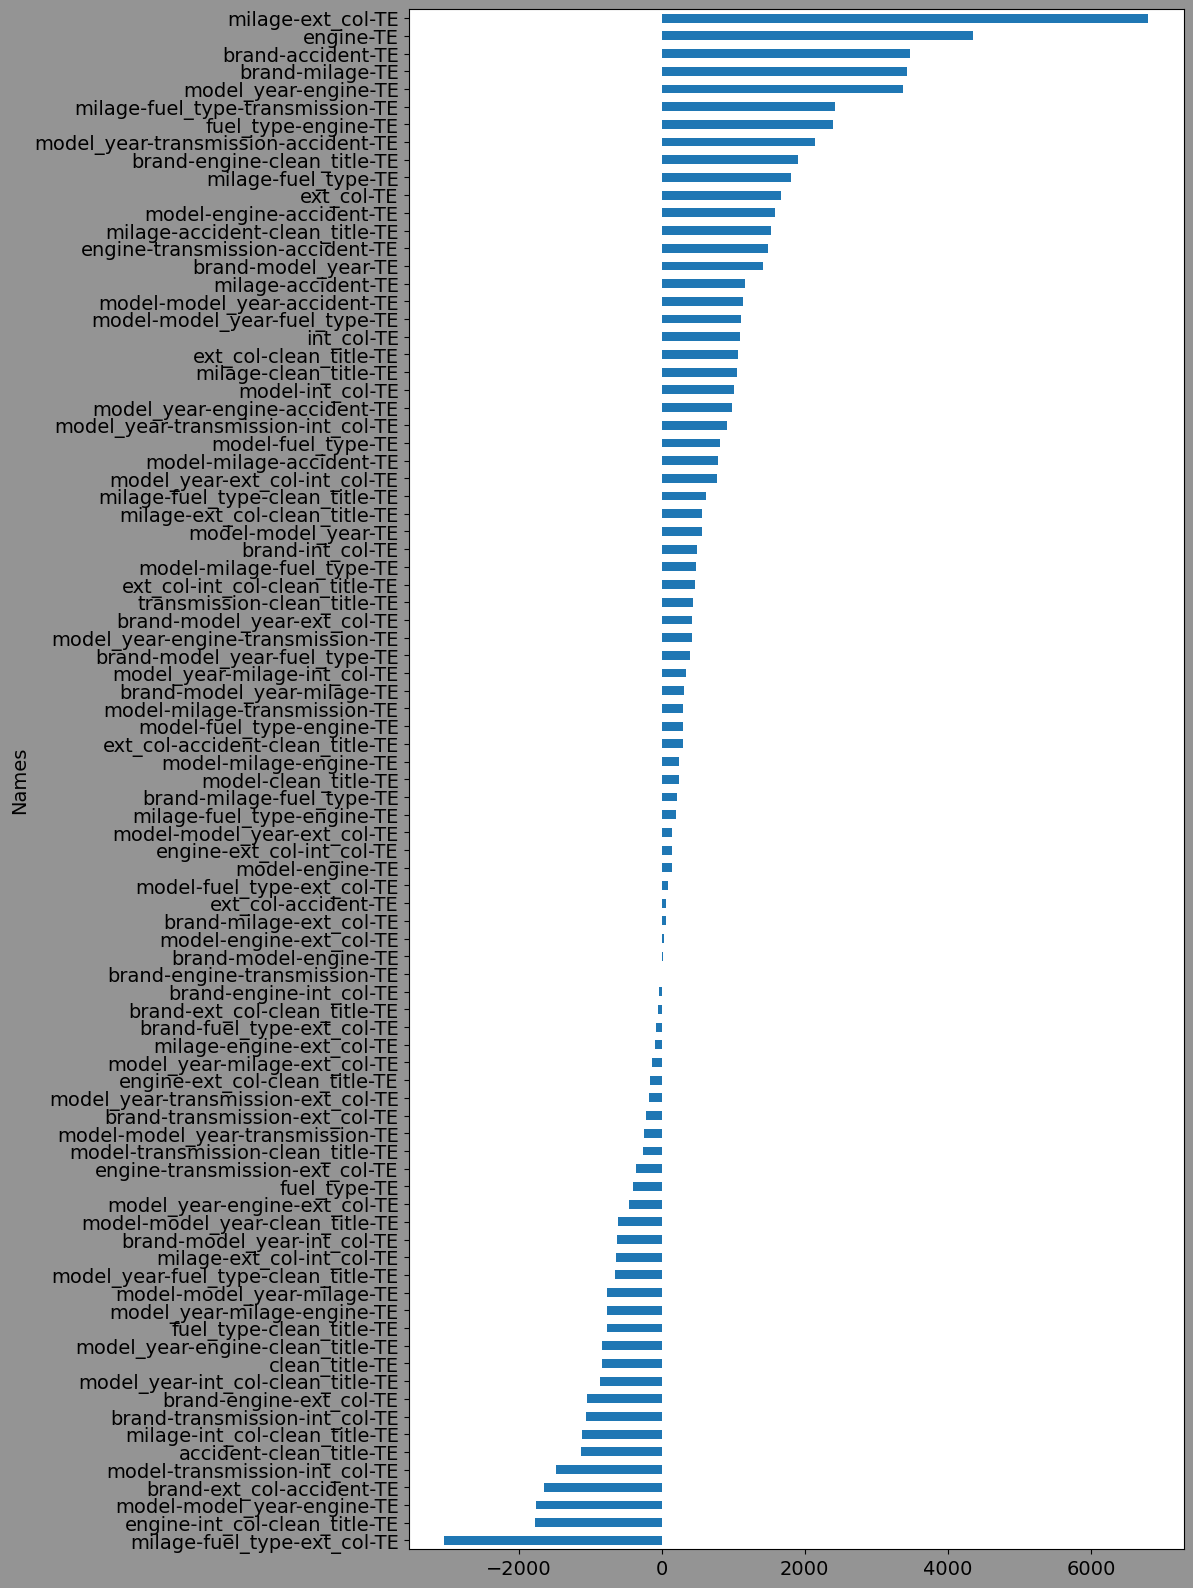

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

data = {'Names': FEATURES,
        'Numbers': model.coef_.to_numpy()}

df = pd.DataFrame(data)
df = df.sort_values("Numbers",ascending=True)
df = df.loc[df.Numbers != 0]

df.plot(x='Names', y='Numbers', kind='barh', legend=False, figsize=(10, 20))

plt.show()
